In [236]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas_datareader.data as web
import requests 
import csv
from bs4 import BeautifulSoup
import matplotlib.pyplot as pl
from pykalman import KalmanFilter
from pykalman import UnscentedKalmanFilter
from matplotlib import pyplot as plt
import seaborn as sns

In [204]:
sns.set_style("whitegrid")

In [98]:
df = pd.read_csv('Users/ogizelenovic/Downloads/fx_Daily_EUR_USD.csv', header=0)
df1 = pd.read_csv('Users/ogizelenovic/Downloads/daily_EZU.csv')

In [99]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close'], dtype='object')

In [100]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df1['Date'] = pd.to_datetime(df1['Date'])

In [102]:
ezu = df1.set_index('Date')
eurusd = df.set_index('timestamp')

In [ ]:
eurusd = eurusd.loc['2010-01-01':'2024-12-31']
ezu = ezu.loc['2010-01-01':'2024-12-31']
ezu = ezu.sort_values(by='Date', ascending=False)

In [109]:
eurusd = eurusd.sort_values(by='timestamp', ascending=False)

In [115]:
eurusd['prev_adj_close'] = eurusd['close'].shift(1)
ezu['prev_adj_close'] = ezu['Close'].shift(1)

In [ ]:
eurusd['log returns'] = np.log(eurusd['close'] / eurusd['prev_adj_close'])
ezu['log returns'] = np.log(ezu['Close'] / ezu['prev_adj_close'])

               Open     High      Low    Close        Volume  prev_adj_close  \
Date                                                                           
2024-12-31  47.3600  47.4900  47.0050  47.2000  2.551246e+06             NaN   
2024-12-30  47.2300  47.3300  46.9650  47.1400  1.249150e+06         47.2000   
2024-12-27  47.4400  47.6250  47.3350  47.5500  7.636770e+05         47.1400   
2024-12-26  47.4769  47.8200  47.4700  47.7400  5.636690e+05         47.5500   
2024-12-24  47.2000  47.5750  47.1400  47.5700  5.549910e+05         47.7400   
...             ...      ...      ...      ...           ...             ...   
2010-01-08  28.3783  28.6873  28.3725  28.6736  3.155769e+05         28.8564   
2010-01-07  28.3119  28.4311  28.2102  28.4311  6.674905e+05         28.6736   
2010-01-06  28.4233  28.6003  28.3490  28.5651  3.853082e+05         28.4311   
2010-01-05  28.5181  28.6218  28.3285  28.4448  1.223824e+06         28.5651   
2010-01-04  28.3832  28.5553  28.1799  2

In [126]:
eurusd = eurusd.reset_index()
ezu = ezu.reset_index()
eurusd = eurusd.rename(columns={'Dates': 'Date'})
merged_df = pd.merge(eurusd, ezu, on='Date', how='inner')

In [228]:
merged_df_dropna = merged_df.dropna()
covmatrix = np.cov(merged_df_dropna['log returns_x'], merged_df_dropna['log returns_y'])
beta = covmatrix[0][1] / covmatrix[0][0]
initial_obs_cov = covmatrix[1][1]

In [149]:
observations = merged_df_dropna['log returns_y']

reshaped = merged_df_dropna['log returns_x']
reshaped = np.reshape(reshaped, [-1, 1, 1])
observation_matrix = reshaped

In [158]:
kf = KalmanFilter(
    em_vars=['transition_covariance', 'observation_covariance'],
    initial_state_mean = beta,
    transition_matrices = 1,
    initial_state_covariance = 1,
    observation_covariance = initial_obs_cov,
    observation_matrices=observation_matrix
)

In [161]:
kf = kf.em(
    X=observations,
    n_iter = 10
)

(smoothed_state_means, smoothed_state_covariances) = kf.smooth(
    X=observations,
)

In [173]:
ss_means = smoothed_state_means.flatten()
ss_covar = smoothed_state_covariances.flatten()

std = np.sqrt(ss_covar)

upper_band = ss_means + 2 * std
lower_band = ss_means - 2 * std

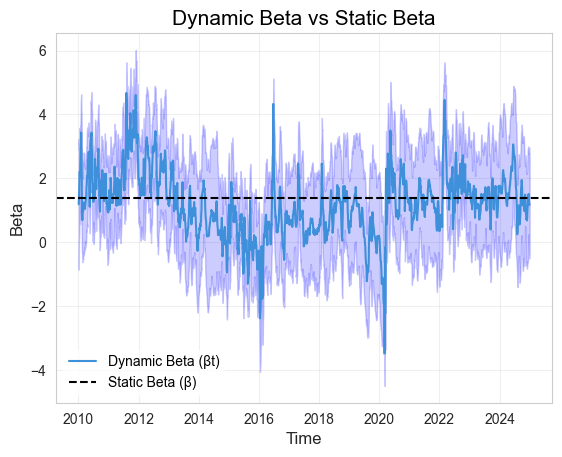

In [218]:
plt.title('Dynamic Beta vs Static Beta', color='black')

plt.plot(merged_df_dropna['Date'], smoothed_state_means, color='C0', label='Dynamic Beta (βt)')
plt.fill_between(merged_df_dropna['Date'], lower_band, upper_band, color='blue', alpha=0.2, )

plt.axhline(y=1.39, color='black', linestyle = '--', label='Static Beta (β)')

plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend(facecolor='white', labelcolor='black')


In [226]:
Q = kf.transition_covariance
print(Q)
R = kf.observation_covariance
print(R)

[[0.25335503]]
[[0.00011846]]


In [277]:
fx_returns_np = merged_df_dropna['log returns_x'].values
observations_np = merged_df_dropna['log returns_y'].values
ukf_state_means = []


In [278]:
initial_cov = np.array([[1]])
Q_array = np.array([[Q]])
R_array = np.array([[R]])


In [279]:
def transition_function(state, noise):
    return state + noise

In [280]:
ukf = UnscentedKalmanFilter(
    transition_function,
    None,
    transition_covariance = Q,
    observation_covariance= R,
    initial_state_mean = np.array([beta]),
    initial_state_covariance = initial_cov
)

current_state_mean = ukf.initial_state_mean
current_state_covariance = ukf.initial_state_covariance
observation_covariance= R_array
transition_covariance = Q_array

for t in range(len(observations_np)):
    current_fx_return = fx_returns_np[t]
    
    current_state_mean, current_state_covariance = ukf.filter_update(
        current_state_mean,
        current_state_covariance,
        observation = observations_np[t],
        observation_function=lambda state, noise: state * current_fx_return + noise
    )
    
    ukf_state_means.append(current_state_mean)

In [309]:
KF_beta = smoothed_state_means.flatten()
UKF_beta = ukf_state_means

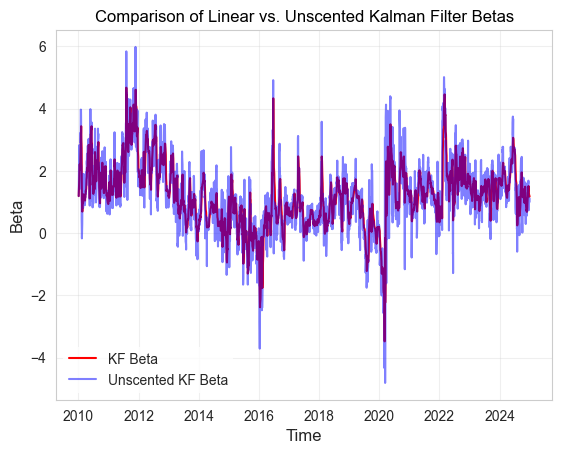

In [313]:
plt.plot(merged_df_dropna['Date'], KF_beta, color='red', label='KF Beta')
plt.plot(merged_df_dropna['Date'], UKF_beta, color='blue', alpha=0.5, label='Unscented KF Beta')

plt.legend(facecolor='white')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.title('Comparison of Linear vs. Unscented Kalman Filter Betas', color='black', fontsize=12)
plt.show()

In [307]:
# --- BEFORE calculating correlation ---

# Make absolutely sure both are 1D arrays.
# It's redundant but safe.
kf_beta_series_flat = np.array(KF_beta).flatten()
ukf_beta_series_flat = np.array(UKF_beta).flatten()

# Now, check their shapes to be certain
print("Shape of KF Beta:", kf_beta_series_flat.shape)
print("Shape of UKF Beta:", ukf_beta_series_flat.shape)


# --- NOW, calculate the correlation ---
# This call should now work correctly.
correlation_matrix = np.corrcoef(kf_beta_series_flat, ukf_beta_series_flat)

print(correlation_matrix)

Shape of KF Beta: (3771,)
Shape of UKF Beta: (3771,)
[[1.         0.89160326]
 [0.89160326 1.        ]]


In [314]:
merged_df.to_csv('/Users/ogizelenovic/Downloads/merged_fin_data', encoding='utf-8-sig', index=False)

In [ ]:

df_to_save = merged_df_dropna.copy()

df_to_save['KF_Beta'] = kf_beta_series_flat
df_to_save['UKF_Beta'] = ukf_beta_series_flat

df_to_save['Smoothed_State_Covariances'] = ss_covar


kalman_output_filename = '/Users/ogizelenovic/Downloads/kalman_filter_results.csv'
df_to_save.to_csv(kalman_output_filename)
print(f"Full Kalman Filter results saved to: {kalman_output_filename}")

optimal_Q = kf.transition_covariance.flatten()[0]
optimal_R = kf.observation_covariance.flatten()[0]

print(f"\nOptimal Q (Transition Covariance): {optimal_Q}")
print(f"Optimal R (Observation Covariance): {optimal_R}")


parameters_filename = '/Users/ogizelenovic/Downloads/kf_parameters.txt'
with open(parameters_filename, 'w') as f:
    f.write(f"Optimal Q: {optimal_Q}\n")
    f.write(f"Optimal R: {optimal_R}\n")

print(f"Key parameters saved to: {parameters_filename}")

Full Kalman Filter results saved to: /Users/ogizelenovic/Downloads/kalman_filter_results.csv

Optimal Q (Transition Covariance): 0.2533550338856525
Optimal R (Observation Covariance): 0.00011846221964561744
Key parameters saved to: /Users/ogizelenovic/Downloads/kf_parameters.txt
